# Node Classification With Graph Neural Networks

Generally speaking, there are three main prediction tasks on graphs: graph-level, node-level & edge-level. 

In graph-level tasks we are looking to make a prediction on the entire graph for example classifying molecules or proteins. For node-level, we aim to predict an attribute at the node level ie node classification or regression. Edge-level seeks to make predictions about the connections between nodes ie whether or not a connection exists between two nodes and potentially what the strength of that connection is.

We will focus on node classification in the following example using the [Cora](https://graphsandnetworks.com/the-cora-dataset/) dataset. 

> "The Cora dataset consists of 2708 scientific publications classified into one of seven classes... Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words."

**Class labels**

- `0: theory`
- `1: reinforcement_learning`
- `2: genetic_algotrithms`
- `3: neural_networks`
- `4: probabilistic_methods`
- `5: case_based`
- `6: rule_learning`

The goal will be to correctly **predict the class label of nodes** in the graph.

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_networkx

import random
import networkx as nx
import matplotlib.pyplot as plt

In [10]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [285]:
# edges are bidirectional, meaning messages can be passed 
# in both directions between a pair of nodes

data.is_undirected()

True

## Visualise the graph

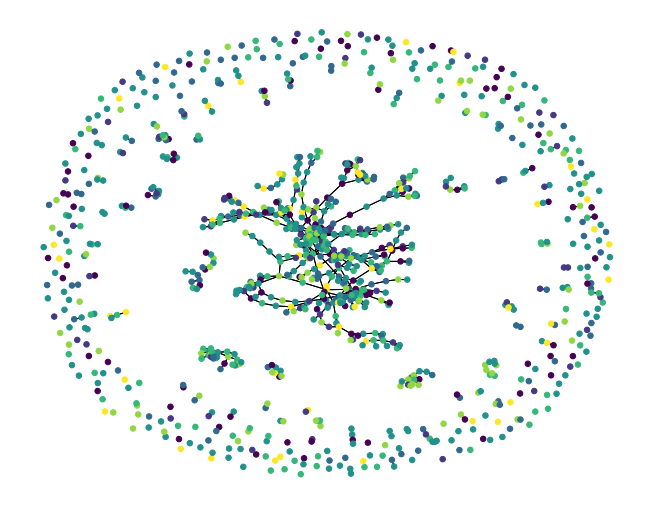

In [13]:
def convert_to_networkx(graph, n_sample=None):

    g = to_networkx(graph, node_attrs=["x"])
    y = graph.y.numpy()

    if n_sample is not None:
        sampled_nodes = random.sample(g.nodes, n_sample)
        g = g.subgraph(sampled_nodes)
        y = y[sampled_nodes]

    return g, y


def plot_graph(g, y):

    plt.figure(figsize=(9, 7))
    nx.draw_spring(g, node_size=30, arrows=False, node_color=y)
    plt.show() 
    
    
g, y = convert_to_networkx(data, n_sample=1000)
plot_graph(g, y)

# Node Classification

For the node classification problem, we are splitting the nodes into train, valid, and test using the `RandomNodeSplit` module from PyG (we are replacing the original split masks in the data as it has a too small train set).


In [14]:
import torch_geometric.transforms as T

split = T.RandomNodeSplit(num_val=0.1, num_test=0.2)
data = split(data)
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

# Baseline MLP classifyer

In [143]:
class MLP(nn.Module):
    """
    simple MLP for classification
    """
    def __init__(self, n_input, n_output, n_hidden=64):
        super().__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(n_input, n_hidden),
            nn.ReLU(),
            
            nn.Linear(n_hidden, n_hidden//2),
            nn.ReLU(),
            
            nn.Linear(n_hidden//2, n_output)
        )
        
    def forward(self, data):
        out = self.layers(data.x)
        return out

In [224]:
def train_node_classifier(model, data, optimiser, criterion, n_epochs=200):
    
    for epoch in range(1, n_epochs+1):
        model.train()
        optimiser.zero_grad()
        
        out = model(data)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        
        loss.backward()
        optimiser.step()
        
        pred = out.argmax(dim=1)
        acc = eval_node_classifier(model, data)
        
        log = f'Epoch: {epoch:03d}, Train Loss: {loss:.3f}, Val Acc: {acc:.3f}'
        
        if epoch % 10 == 0:
            print(log)
            
    return model



def eval_node_classifier(model, data):

    model.eval()
    pred = model(data).argmax(dim=1)
    
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    acc = int(correct) / int(data.test_mask.sum())
    
    return acc

In [162]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# init
mlp = MLP(n_input=dataset.num_node_features, n_output=dataset.num_classes).to(device)

# optimiser and loss
optimizer_mlp = torch.optim.Adam(mlp.parameters(), lr=0.01, weight_decay=5e-4)

criterion = nn.CrossEntropyLoss()

In [261]:
mlp(data).shape

#criterion(mlp(data), data.y)

torch.Size([2708, 7])

In [163]:
# TRAIN
# ------

mlp = train_node_classifier(mlp, data, optimizer_mlp, criterion, n_epochs=150)

test_acc = eval_node_classifier(mlp, data)
print(f'Test Acc: {test_acc:.3f}')

Epoch: 010, Train Loss: 0.958, Val Acc: 0.631
Epoch: 020, Train Loss: 0.109, Val Acc: 0.738
Epoch: 030, Train Loss: 0.017, Val Acc: 0.725
Epoch: 040, Train Loss: 0.011, Val Acc: 0.729
Epoch: 050, Train Loss: 0.013, Val Acc: 0.725
Epoch: 060, Train Loss: 0.011, Val Acc: 0.723
Epoch: 070, Train Loss: 0.009, Val Acc: 0.736
Epoch: 080, Train Loss: 0.008, Val Acc: 0.734
Epoch: 090, Train Loss: 0.008, Val Acc: 0.736
Epoch: 100, Train Loss: 0.007, Val Acc: 0.742
Epoch: 110, Train Loss: 0.007, Val Acc: 0.742
Epoch: 120, Train Loss: 0.006, Val Acc: 0.742
Epoch: 130, Train Loss: 0.006, Val Acc: 0.745
Epoch: 140, Train Loss: 0.006, Val Acc: 0.747
Epoch: 150, Train Loss: 0.006, Val Acc: 0.745
Test Acc: 0.745


# GCN for Node Classification

**Architecture**

This is a simple GCN that we will train to compare performance against the baseline MLP. 

The architecture is fairly straightforward, two convolutional layers with a ReLU activation function between them. This is a very shallow network, in practice you would experiment with deep vs wide neural nets to understand the effects and trade-offs between computational complexity and predictive accuracy. 

**Loss**

For classification tasks with $C$ targets, the Cross Entropy criterion is a good choice. The loss function computes the cross entropy between input logits and target. For cross entropy in PyTorch, the input is expected to contain the unnormalized logits for each class. In general, these do not need to be positive or sum to 1.

In [274]:
class GCN(nn.Module):
    def __init__(self, in_features, out_features, n_hidden=16):
        super().__init__()
        
        self.conv1 = GCNConv(in_features, n_hidden)
        self.conv2 = GCNConv(n_hidden, out_features)
        
    def forward(self, data):
        
        x, edge_index = data.x, data.edge_index
        
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        out = self.conv2(x, edge_index)
        
        return out

In [275]:
gcn = GCN(dataset.num_node_features, dataset.num_classes).to(device)

optimizer_gcn = torch.optim.Adam(gcn.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

In [276]:
# FYI
dataset.num_node_features, data.num_node_features

(1433, 1433)

In [277]:
gcn = train_node_classifier(gcn, data, optimizer_gcn, criterion)

Epoch: 010, Train Loss: 0.682, Val Acc: 0.751
Epoch: 020, Train Loss: 0.121, Val Acc: 0.786
Epoch: 030, Train Loss: 0.029, Val Acc: 0.777
Epoch: 040, Train Loss: 0.014, Val Acc: 0.785
Epoch: 050, Train Loss: 0.013, Val Acc: 0.787
Epoch: 060, Train Loss: 0.014, Val Acc: 0.805
Epoch: 070, Train Loss: 0.016, Val Acc: 0.812
Epoch: 080, Train Loss: 0.017, Val Acc: 0.810
Epoch: 090, Train Loss: 0.017, Val Acc: 0.811
Epoch: 100, Train Loss: 0.016, Val Acc: 0.810
Epoch: 110, Train Loss: 0.015, Val Acc: 0.808
Epoch: 120, Train Loss: 0.014, Val Acc: 0.808
Epoch: 130, Train Loss: 0.013, Val Acc: 0.811
Epoch: 140, Train Loss: 0.013, Val Acc: 0.810
Epoch: 150, Train Loss: 0.012, Val Acc: 0.812
Epoch: 160, Train Loss: 0.012, Val Acc: 0.811
Epoch: 170, Train Loss: 0.011, Val Acc: 0.811
Epoch: 180, Train Loss: 0.011, Val Acc: 0.810
Epoch: 190, Train Loss: 0.011, Val Acc: 0.810
Epoch: 200, Train Loss: 0.010, Val Acc: 0.810


### Slightly different GCN architecture

This architecture is identical to the first but adds in a dropout layer. Dropout is a widely used technique to reduce overfitting in neural networks. During training, dropout randomly ignores some number of layer outputs. This has the effect of reducing the capacity or "thinnning-out" the network. It also regularises the network by helping ensure that nodes withing the network are not codependent on each other.

The loss has been changed to `NLLLoss` which, when preceeded by `LogSoftmax` is an equivalent to `CrossEntropyLoss`.

In [278]:
class GCN2(torch.nn.Module):
    def __init__(self, in_features, out_features, n_hidden=16):
        super().__init__()
        self.conv1 = GCNConv(in_features, n_hidden)
        self.conv2 = GCNConv(n_hidden, out_features)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [279]:
gcn2 = GCN2(dataset.num_node_features, dataset.num_classes).to(device)

optimizer_gcn2 = torch.optim.Adam(gcn2.parameters(), lr=0.01, weight_decay=5e-4)
criterion2 = nn.NLLLoss()

In [257]:
gcn2 = train_node_classifier(gcn2, data, optimizer_gcn2, criterion2)

Epoch: 010, Train Loss: 0.874, Val Acc: 0.755
Epoch: 020, Train Loss: 0.260, Val Acc: 0.800
Epoch: 030, Train Loss: 0.126, Val Acc: 0.799
Epoch: 040, Train Loss: 0.060, Val Acc: 0.783
Epoch: 050, Train Loss: 0.046, Val Acc: 0.790
Epoch: 060, Train Loss: 0.040, Val Acc: 0.791
Epoch: 070, Train Loss: 0.042, Val Acc: 0.791
Epoch: 080, Train Loss: 0.053, Val Acc: 0.791
Epoch: 090, Train Loss: 0.048, Val Acc: 0.796
Epoch: 100, Train Loss: 0.031, Val Acc: 0.804
Epoch: 110, Train Loss: 0.028, Val Acc: 0.799
Epoch: 120, Train Loss: 0.032, Val Acc: 0.808
Epoch: 130, Train Loss: 0.042, Val Acc: 0.793
Epoch: 140, Train Loss: 0.053, Val Acc: 0.812
Epoch: 150, Train Loss: 0.042, Val Acc: 0.796
Epoch: 160, Train Loss: 0.023, Val Acc: 0.805
Epoch: 170, Train Loss: 0.020, Val Acc: 0.801
Epoch: 180, Train Loss: 0.023, Val Acc: 0.809
Epoch: 190, Train Loss: 0.036, Val Acc: 0.804
Epoch: 200, Train Loss: 0.029, Val Acc: 0.813


Overall the first GCN performed slightly better than the second, however both performed better than the MLP *(~17% uplift)*.

Let's check the first few predictions against the target to see the results

In [314]:
# predictions
preds = gcn(data).argmax(dim=-1)

# true values
data.y[:10]

tensor([3, 4, 4, 0, 3, 2, 0, 3, 3, 2])

In [315]:
preds[:10]

tensor([3, 4, 4, 0, 3, 2, 0, 3, 3, 2])